In [1]:
# project root へ移動
%cd ..
%pwd

/Users/heste/workspace/soccernet/tracklab


/Users/heste/workspace/soccernet/sn-gamestate/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/Users/heste/workspace/soccernet/tracklab'

In [2]:
import os
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
import numpy as np
import pandas as pd

# Dataframe 表示時の truncation を防ぐ
pd.set_option('display.max_colwidth', 200)

In [3]:
from dataclasses import dataclass
from glob import glob

@dataclass
class GSR_States:
    gamestate_zip_file: Path
    gamestate_summary_file: Path
    gamestate_file: Path
    gamestate_images_file: Path
    gamestate_df: pd.DataFrame
    image_df: pd.DataFrame
    
    @classmethod
    def initialize(cls, gamestate_zip_file: Path):
        gamestate_zip_file = gamestate_zip_file
        
        parent_dir = gamestate_zip_file.parent
        
        if not (parent_dir / "summary.json").exists():
            zipfile.ZipFile(gamestate_zip_file).extractall(parent_dir)
        
        # 見つける the summary.json file
        gamestate_summary_file = parent_dir / "summary.json"
        
        # 見つける the / {data_id}.pkl file
        for path in glob(str(parent_dir / "*.pkl")):
            if "_image.pkl" in path:
                gamestate_images_file = Path(path)
            else:
                # {data_id} はどこにも記載されていないので、とりあえず_image.pklではないものを gamestate_file とする
                gamestate_file = Path(path)
        
        gamestate_df = pd.read_pickle(gamestate_file)
        image_df = pd.read_pickle(gamestate_images_file)
        
        return GSR_States(
            gamestate_zip_file=gamestate_zip_file,
            gamestate_summary_file=gamestate_summary_file,
            gamestate_file=gamestate_file,
            gamestate_images_file=gamestate_images_file,
            gamestate_df=gamestate_df,
            image_df=image_df
        )

class NotebookArgs:
    # GSR 1件 テスト映像
    gsr_path = Path("outputs/sn-gamestate/2024-07-03/12-10-22/states/sn-gamestate-1.pklz")
    
    # GSR 20件程度 テスト映像
    gsr_exp002_path = Path("outputs/sn-gamestate-1/2024-09-13/17-11-26/states/sn-gamestate-1.pklz")
    
    # v2 1件 2fps 224p の映像
    snv2_path = Path("outputs/sn-gamestate-1/2024-08-26/18-01-52/states/sn-gamestate-1.pklz")
    
    # v2 1件 2fps 720p の映像
    snv2_exp003_path = Path("outputs/sn-gamestate-exp003/2024-09-12/22-43-17/states/sn-gamestate-exp003.pklz")
    
    gsr_exp007_path = Path("outputs/sn-gamestate-gsr/2024-11-20/18-25-22/states/sn-gamestate-gsr.pklz")
    
    v3_720p_exp005_path = Path("outputs/sn-gamestate-v3-720p/2024-11-28/01-23-26/states/sn-gamestate-v3-720p.pklz")

    v3_720p_exp007_path = Path("outputs/sn-gamestate-v3-720p/2024-11-28/12-17-57/states/sn-gamestate-v3-720p.pklz")


In [4]:
# sn-gamestate test data で実行した結果を読み込む
# gsr_states = GSR_States.initialize(NotebookArgs.gsr_path)
# gsr_exp002_states = GSR_States.initialize(NotebookArgs.gsr_exp002_path)
# soccernetv2_states = GSR_States.initialize(NotebookArgs.snv2_path)
# exp003_states = GSR_States.initialize(NotebookArgs.snv2_exp003_path)
gsr_exp007 = GSR_States.initialize(NotebookArgs.gsr_exp007_path)
v3_720p_exp005 = GSR_States.initialize(NotebookArgs.v3_720p_exp005_path)
v3_720p_exp007 = GSR_States.initialize(NotebookArgs.v3_720p_exp007_path)

In [6]:
def bbox_to_3x3_position(bbox_ltwh, image_shape = [720, 1280]) -> str:
    image_height, image_width = image_shape
    left, top, width, height = bbox_ltwh
    
    bbox_center_x = left + width / 2
    bbox_center_y = top + height / 2
    
    assert 0 <= bbox_center_x <= image_width
    assert 0 <= bbox_center_y <= image_height
    
    # 3x3 grid に変換
    x = int(3 * bbox_center_x / image_width)
    y = int(3 * bbox_center_y / image_height)
    
    x_str_map = {
        0: "left",
        1: "middle",
        2: "right"
    }
    
    y_str_map = {
        0: "top",
        1: "middle",
        2: "bottom"
    }
    
    return f"{y_str_map[y]}-{x_str_map[x]}"

In [7]:
gsr_exp007.gamestate_df.columns

Index(['image_id', 'bbox_ltwh', 'bbox_conf', 'video_id', 'category_id',
       'body_masks', 'embeddings', 'role_confidence', 'role_detection',
       'visibility_scores', 'age', 'costs', 'hits', 'matched_with', 'state',
       'time_since_update', 'track_bbox_kf_ltwh', 'track_bbox_pred_kf_ltwh',
       'track_id', 'bbox_pitch', 'jersey_number_confidence',
       'jersey_number_detection', 'jersey_number', 'role', 'team_cluster',
       'team', 'ignored'],
      dtype='object')

In [8]:
# bbox_ltwh, bbox_pitch の比較
gsr_exp007.gamestate_df[["bbox_ltwh", "bbox_pitch"]].head(1)

,bbox_ltwh,bbox_pitch
0,"[1675.6746, 608.2425, 47.645752, 89.43219]","{'x_bottom_left': -22.613178796825224, 'y_bottom_left': 11.60163210908214, 'x_bottom_right': -21.371752175476058, 'y_bottom_right': 11.244338058529385, 'x_bottom_middle': -21.98986564591245, 'y_bo..."


In [9]:
gsr_exp007.gamestate_df[["bbox_ltwh", "bbox_pitch"]].head(1)

,bbox_ltwh,bbox_pitch
0,"[1675.6746, 608.2425, 47.645752, 89.43219]","{'x_bottom_left': -22.613178796825224, 'y_bottom_left': 11.60163210908214, 'x_bottom_right': -21.371752175476058, 'y_bottom_right': 11.244338058529385, 'x_bottom_middle': -21.98986564591245, 'y_bo..."


In [8]:
gsr_exp007.image_df.columns

Index(['video_id', 'frame', 'file_path', 'is_labeled', 'id', 'lines',
       'parameters'],
      dtype='object')

In [ ]:
gsr_exp007.gamestate_df

In [7]:
# track_idの数 = 同一オブジェクトとして認識された数
# 完全バラバラなのか、ある程度フレーム間で同一オブジェクトが認識されているのかを確認する指標として使えるのでは？
# 0.09 -> これがどれくらいの割合なのかがわからない
def obj_num(state: GSR_States):
    snv2_rate = state.gamestate_df["track_id"].nunique() / len(state.gamestate_df)

    # gsrでもやる
    gsr_rate = state.gamestate_df["track_id"].nunique() / len(state.gamestate_df)

    print(f"SNv2: {snv2_rate:.3f}, GSR: {gsr_rate:.3f}") 

# SNv2: 0.091, GSR: 0.011 
# 仮説と真逆の結果になった
# うーん、これはどういうことなのか

In [ ]:
soccernetv2_states.gamestate_df[["image_id", "bbox_ltwh", "jersey_number_detection", "role", "team"]].head(20)

,image_id,bbox_ltwh,jersey_number_detection,role,team
0,1005_1000001,"[243.80844, 160.7894, 8.895187, 29.814362]",NaN,player,right
1,1005_1000001,"[7.6811314, 144.12244, 7.3517103, 29.524902]",NaN,player,left
2,1005_1000001,"[129.51042, 106.73213, 6.3617706, 21.203796]",NaN,ball,nan
3,1005_1000001,"[301.83694, 111.528336, 6.7047424, 24.376312]",NaN,player,left
4,1005_1000001,"[140.21762, 88.23965, 6.615967, 15.968224]",NaN,ball,nan
5,1005_1000001,"[368.69278, 88.37085, 9.361664, 18.446312]",NaN,player,left
6,1005_1000001,"[200.84027, 109.04617, 9.060608, 19.065567]",NaN,player,left
7,1005_1000001,"[112.754944, 95.72863, 7.3474884, 16.682106]",NaN,player,left
8,1005_1000001,"[178.49332, 105.726234, 9.825851, 16.806038]",NaN,player,left
9,1005_1000001,"[223.4625, 100.75325, 6.9635925, 18.82914]",NaN,player,left


In [14]:
soccernetv2_states.gamestate_df["jersey_number_detection"].describe()

count     404
unique     44
top        00
freq       98
Name: jersey_number_detection, dtype: object

In [15]:
soccernetv2_states.gamestate_df["jersey_number_confidence"].describe()

count    38282.000000
mean         0.008563
std          0.085263
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: jersey_number_confidence, dtype: float64

In [16]:
gsr_states.gamestate_df.loc[
    gsr_states.gamestate_df["jersey_number_detection"].notnull(), 
    ["image_id", "jersey_number_detection", "role", "team"]].head(20)

,image_id,jersey_number_detection,role,team
48,3116000004,33,player,right
76,3116000006,93,player,left
80,3116000006,33,player,right
91,3116000007,19,player,left
107,3116000008,13,player,left
112,3116000008,33,player,right
123,3116000009,33,player,left
128,3116000009,33,player,right
139,3116000010,93,player,left
144,3116000010,3,player,right


In [87]:
exp003_states.gamestate_df.loc[exp003_states.gamestate_df["jersey_number_detection"].notnull() & (exp003_states.gamestate_df["role_detection"] == "player"), ["image_id", "jersey_number_detection", "role", "team"]]

,image_id,jersey_number_detection,role,team
415,1005_1000042,00,player,right
596,1005_1000059,2,player,right
697,1005_1000071,00,player,right
698,1005_1000071,11,player,right
702,1005_1000072,11,player,right
...,...,...,...,...
50577,1005_1005391,10,player,left
50596,1005_1005392,18,player,left
50613,1005_1005393,42,player,left
50615,1005_1005393,18,player,left


In [18]:
soccernetv2_states.image_df.columns

Index(['frame', 'id', 'video_id', 'file_path', 'lines', 'parameters'], dtype='object')

In [32]:
soccernetv2_states.image_df[["frame", "lines", "parameters"]].head()

,frame,lines,parameters
id,,,
1005_1000001,0,"{'Circle central': [{'x': 0.47912087912087914, 'y': 0.49609375}, {'x': 0.5758241758241758, 'y': 0.4921875}, {'x': 0.6945054945054945, 'y': 0.52734375}, {'x': 0.6681318681318681, 'y': 0.640625}, {'...","{'pan_degrees': 2.6825742721557617, 'tilt_degrees': 67.84307861328125, 'roll_degrees': -0.8659389615058899, 'position_meters': [0.06817737966775894, 78.21742248535156, -24.714509963989258], 'x_foc..."
1005_1000002,1,"{'Circle central': [{'x': 0.47692307692307695, 'y': 0.65625}, {'x': 0.578021978021978, 'y': 0.6640625}, {'x': 0.6945054945054945, 'y': 0.625}, {'x': 0.6615384615384615, 'y': 0.51171875}, {'x': 0.5...","{'pan_degrees': 3.532975196838379, 'tilt_degrees': 67.34796142578125, 'roll_degrees': -1.3986132144927979, 'position_meters': [-0.01665681041777134, 81.40090942382812, -23.908008575439453], 'x_foc..."
1005_1000003,2,"{'Circle central': [{'x': 0.4835164835164835, 'y': 0.46875}, {'x': 0.5846153846153846, 'y': 0.4921875}, {'x': 0.7186813186813187, 'y': 0.5390625}, {'x': 0.6505494505494506, 'y': 0.6484375}, {'x': ...","{'pan_degrees': 2.5546207427978516, 'tilt_degrees': 67.7827835083008, 'roll_degrees': -1.1426992416381834, 'position_meters': [-0.2882041931152344, 80.49137878417969, -24.0777587890625], 'x_focal_..."
1005_1000004,3,"{'Circle central': [{'x': 0.7252747252747253, 'y': 0.6484375}, {'x': 0.5956043956043956, 'y': 0.6796875}, {'x': 0.4747252747252747, 'y': 0.68359375}, {'x': 0.35384615384615387, 'y': 0.66015625}, {...","{'pan_degrees': -2.5973498821258554, 'tilt_degrees': 68.51156616210938, 'roll_degrees': -0.047029443085193634, 'position_meters': [0.3538846969604492, 78.7445297241211, -24.351716995239258], 'x_fo..."
1005_1000005,4,"{'Circle central': [{'x': 0.5208791208791209, 'y': 0.5}, {'x': 0.3868131868131868, 'y': 0.515625}, {'x': 0.2703296703296703, 'y': 0.60546875}, {'x': 0.3978021978021978, 'y': 0.6875}, {'x': 0.54285...","{'pan_degrees': -4.921325206756593, 'tilt_degrees': 68.29093170166016, 'roll_degrees': 0.09661880135536191, 'position_meters': [-0.9640040993690491, 80.0218276977539, -23.958696365356445], 'x_foca..."


In [34]:
gsr_states.gamestate_df.index

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       9336, 9337, 9338, 9339, 9340, 9341, 9342, 9343, 9344, 9345],
      dtype='int64', length=9346)

In [22]:
# SoccerNet-v2 exp001 背番号の認識がうまくいっているレコードを表示
soccernetv2_states.gamestate_df.loc[
    soccernetv2_states.gamestate_df["jersey_number_confidence"] > 0.5, ["image_id", "jersey_number_detection", "jersey_number_confidence", "role", "team"]].head(20)

,image_id,jersey_number_detection,jersey_number_confidence,role,team
429,1005_1000058,10,0.953834,player,right
504,1005_1000071,00,0.997413,player,right
510,1005_1000072,11,0.744189,player,right
528,1005_1000079,00,0.996611,player,right
641,1005_1000100,28,0.988316,player,right
659,1005_1000101,28,1.000000,player,right
680,1005_1000104,2,0.964653,player,right
689,1005_1000105,11,0.990380,player,right
734,1005_1000109,9,0.542806,player,right
929,1005_1000131,09,0.513052,player,right


In [25]:
# GSR test 背番号の認識がうまくいっているレコードを表示

gsr_states.gamestate_df.loc[
    gsr_states.gamestate_df["jersey_number_confidence"] > 0.5, 
    ["image_id", "jersey_number_detection", "jersey_number_confidence", "role", "team"]
].head(20)

,image_id,jersey_number_detection,jersey_number_confidence,role,team
48,3116000004,33,0.999999,player,right
76,3116000006,93,0.894604,player,left
80,3116000006,33,0.999996,player,right
91,3116000007,19,0.754866,player,left
107,3116000008,13,0.831190,player,left
112,3116000008,33,0.999995,player,right
123,3116000009,33,0.995262,player,left
128,3116000009,33,1.000000,player,right
139,3116000010,93,0.998286,player,left
144,3116000010,3,0.820008,player,right


In [14]:
# GSR test 背番号の認識がうまくいっているレコードを表示

exp003_states.gamestate_df.loc[
    exp003_states.gamestate_df["jersey_number_confidence"] > 0.5, 
    ["image_id", "jersey_number_detection", "jersey_number_confidence", "role", "team"]
].head(20)

,image_id,jersey_number_detection,jersey_number_confidence,role,team
415,1005_1000042,00,1.000000,player,right
596,1005_1000059,2,0.901147,player,right
615,1005_1000064,5,0.962113,player,right
697,1005_1000071,00,1.000000,player,right
698,1005_1000071,11,0.845412,player,right
702,1005_1000072,11,0.718771,player,right
707,1005_1000072,00,1.000000,player,right
710,1005_1000073,11,0.865649,player,right
714,1005_1000073,00,1.000000,player,right
717,1005_1000074,00,1.000000,player,right


In [24]:
# nunber: 28	confidence: 1.0 の画像についての情報を表示
soccernetv2_states.gamestate_df.loc[
    soccernetv2_states.gamestate_df["image_id"] == "1005_1000101", 
    ["image_id", "jersey_number_detection", "jersey_number_confidence", "role", "team"]
]

,image_id,jersey_number_detection,jersey_number_confidence,role,team
650,1005_1000101,NaN,0.0,player,right
651,1005_1000101,NaN,0.0,player,right
652,1005_1000101,NaN,0.0,player,right
653,1005_1000101,NaN,0.0,player,right
654,1005_1000101,NaN,0.0,player,right
655,1005_1000101,NaN,0.0,player,right
656,1005_1000101,NaN,0.0,player,right
657,1005_1000101,NaN,0.0,player,right
658,1005_1000101,NaN,0.0,player,right
659,1005_1000101,28,1.0,player,right


In [17]:
# nunber: 28	confidence: 1.0 の画像についての情報を表示
exp003_states.gamestate_df.loc[
    exp003_states.gamestate_df["image_id"] == "1005_1000101", 
    ["image_id", "jersey_number_detection", "jersey_number_confidence", "role", "team", "bbox_ltwh"]
]

,image_id,jersey_number_detection,jersey_number_confidence,role,team,bbox_ltwh
907,1005_1000101,NaN,0.0,player,right,"[153.0094, 135.56726, 235.3341, 578.15063]"
908,1005_1000101,NaN,0.0,player,right,"[712.9668, 97.75928, 269.573, 569.2031]"
909,1005_1000101,28,1.0,player,right,"[272.69604, 126.64844, 310.56128, 582.92615]"
910,1005_1000101,NaN,0.0,player,right,"[521.3635, 49.18927, 190.74744, 467.8197]"
911,1005_1000101,NaN,0.0,player,right,"[980.4829, 65.16107, 208.88647, 475.29663]"
912,1005_1000101,NaN,0.0,player,right,"[0.24652863, 371.494, 101.78488, 343.13162]"
913,1005_1000101,NaN,0.0,player,right,"[61.342472, 383.95923, 125.392944, 115.45123]"
914,1005_1000101,NaN,0.0,player,right,"[0.05418396, 238.16867, 167.01042, 221.81335]"
915,1005_1000101,NaN,0.0,player,right,"[801.52344, 482.85834, 297.58716, 234.11304]"
916,1005_1000101,NaN,0.0,player,right,"[1157.7975, 140.54773, 121.202515, 411.89026]"


In [122]:
# 概要: 背番号の認識割合
# 目的: 画像サイズの違いが、背番号認識の精度にどのような影響を与えるかを調査する
# 結果: exp003(720p)だと、GSR(1080p)に近い認識割合を出している

# 手順
def get_jersey_number_rate(states: GSR_States):
    detected_size = (
        states
        .gamestate_df
        .loc[
            states.gamestate_df["jersey_number_detection"].notnull()
            & states.gamestate_df["role_detection"].isin(["player", "goolkeeper"])
        ]
        .size
    )
    should_detect_size =  (
        states
        .gamestate_df
        .loc[
            states.gamestate_df["role_detection"].isin(["player", "goolkeeper"])
        ]
        .size
    )
    return detected_size / should_detect_size

# snv2 exp001
snv2_rate = get_jersey_number_rate(soccernetv2_states)

# exp003
exp003_rate = get_jersey_number_rate(exp003_states)


# gsr
gsr_rate = get_jersey_number_rate(gsr_states)


# gsr exp002
gsr_exp002_rate = get_jersey_number_rate(gsr_exp002_states)

print("背番号の認識割合(Not Null)")
print(f"SNv2: {snv2_rate:.3f}, exp003: {exp003_rate:.3f}")
print(f"GSR: {gsr_rate:.3f}, GSR exp002: {gsr_exp002_rate:.3f}")
print(f'{gsr_exp002_rate:.3%}')



背番号の認識割合(Not Null)
SNv2: 0.013, exp003: 0.039
GSR: 0.041, GSR exp002: 0.016
1.550%


Text(0.5, 1.0, 'gsr')

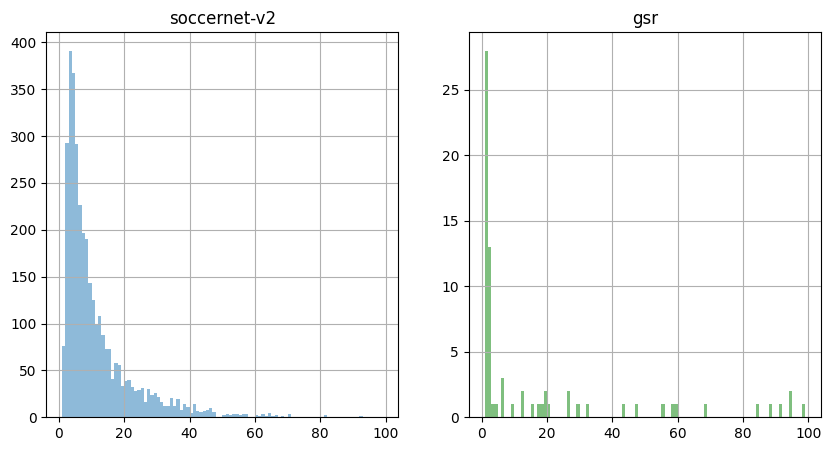

In [125]:
# 概要: 各objectが持続するフレーム数の分布を調べる
# 目的: 2fpsなv2なデータで、どれくらいうまく trackingいってるのかを調べる
# 結果: 分布の歪度と裾の広さはあまり変わらなかった。そもそも gsr データで全然うまくいってない..?
# 山が5付近, 5 (frame) /  2 (frame/sec) = 2.5 sec ごとにオブジェクトが更新されている（画面が切り替わる？）
# 2.5secごとにシーン切り替えはちょっと早くない？

# 手順は以下の通り
# soccernetv2_statesとgsr_statesのヒストグラムを比較する
# track_idでグルーピングして、サイズの分布をみる
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

soccernetv2_states.gamestate_df.groupby("track_id").size().hist(bins=range(1, 100), ax=ax[0], alpha=0.5, label="soccernetv2")
ax[0].set_title("soccernet-v2")

gsr_states.gamestate_df.groupby("track_id").size().hist(bins=range(1, 100), ax=ax[1], alpha=0.5, label="gsr", color="green")
ax[1].set_title("gsr")


Text(0.5, 1.0, 'gsr exp002')

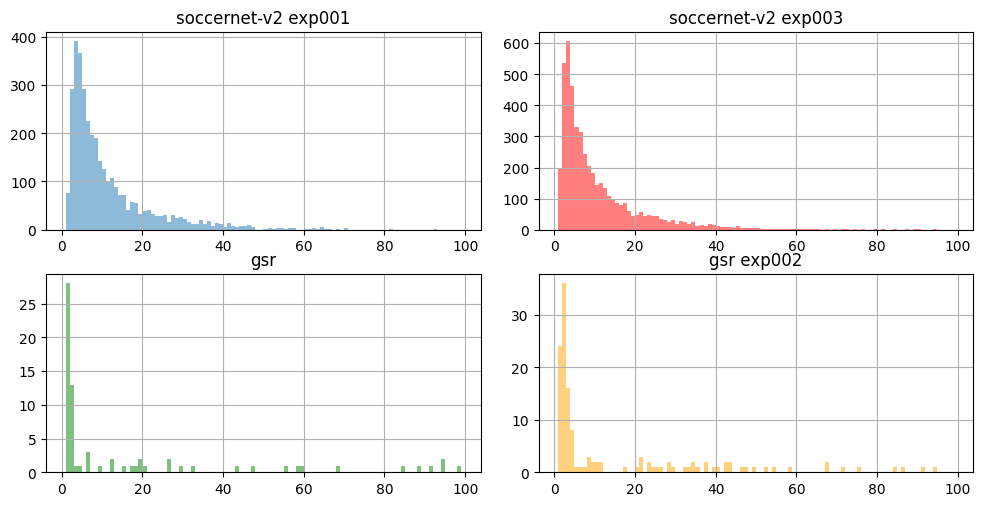

In [126]:
# 概要: 各objectが持続するフレーム数の分布を調べる
# 目的: 追加実験データで、どれくらいうまく trackingいってるのかを調べる
# Soccernet-v2 -> 解像度高くてもあまり変わらなかった
# GSR -> 「そもそも gsr データで全然うまくいってない..?」と思って追加実験を行ったが、大体同じ結果だった。こんなもんぽい

fig, ax = plt.subplots(2, 2, figsize=(10, 5))

fig.tight_layout()

# soccenet v2 exp001
soccernetv2_states.gamestate_df.groupby("track_id").size().hist(bins=range(1, 100), ax=ax[0, 0], alpha=0.5, label="soccernetv2")
ax[0, 0].set_title("soccernet-v2 exp001")
# soccernet-v2 exp003
exp003_states.gamestate_df.groupby("track_id").size().hist(bins=range(1, 100), ax=ax[0, 1], alpha=0.5, label="exp003", color="red")
ax[0, 1].set_title("soccernet-v2 exp003")
# gsr
gsr_states.gamestate_df.groupby("track_id").size().hist(bins=range(1, 100), ax=ax[1, 0], alpha=0.5, label="gsr", color="green")
ax[1, 0].set_title("gsr")
# gsr exp002
gsr_exp002_states.gamestate_df.groupby("track_id").size().hist(bins=range(1, 100), ax=ax[1, 1], alpha=0.5, label="gsr_exp002", color="orange")
ax[1, 1].set_title("gsr exp002")

In [110]:
# 概要: track_id の数をシンプルに比較する
# 目的: tracking の精度を比較する(fpsの違いを考慮する必要がある)
# 結果: 画像一枚あたりのtrackingオブジェクトのユニーク数が、GSRと比べてSNV2は5倍程度多い
# これは、fpsの違いが影響しているのかもしれない (fpsを上げるべきかも...)

# 手順
# 1. track_id の数を比較する
def count_track_id(states: GSR_States):
    return states.gamestate_df["track_id"].nunique()

def count_track_id_by_image_num(states: GSR_States):
    return count_track_id(states) / states.gamestate_df["image_id"].nunique()

snv2_track_result = count_track_id(soccernetv2_states)
exp003_track_result = count_track_id(exp003_states)

gsr_track_result = count_track_id(gsr_states)
gsr_exp002_track_result = count_track_id(gsr_exp002_states)

print("trackingオブジェクトのユニーク数")
print(f"SNv2-exp001: {snv2_track_result}, SNv2-exp003: {exp003_track_result}")
print(f"gsr: {gsr_track_result}, gsr-exp002: {gsr_exp002_track_result}")
print("")
print("画像一枚あたりのtrackingオブジェクトのユニーク数")
print(f"SNv2-exp001: {count_track_id_by_image_num(soccernetv2_states):.2f}, SNv2-exp003: {count_track_id_by_image_num(exp003_states):.2f}")
print(f"gsr: {count_track_id_by_image_num(gsr_states):.2f}, gsr-exp002: {count_track_id_by_image_num(gsr_exp002_states):.2f}")

trackingオブジェクトのユニーク数
SNv2-exp001: 3478, SNv2-exp003: 4799
gsr: 106, gsr-exp002: 148

画像一枚あたりのtrackingオブジェクトのユニーク数
SNv2-exp001: 0.66, SNv2-exp003: 0.89
gsr: 0.14, gsr-exp002: 0.20


Text(0.5, 1.0, 'gsr-jersey')

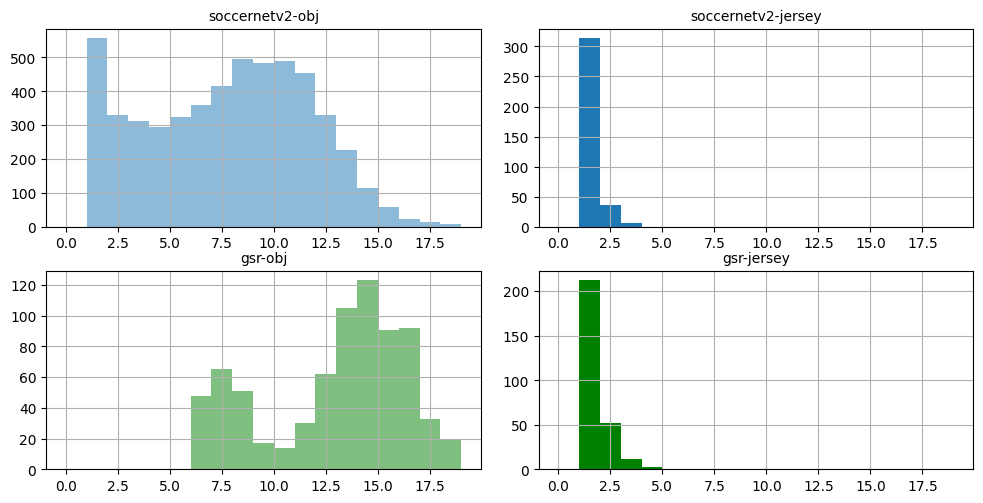

In [119]:

# 概要:画像一枚につき、(1)何このオブジェクトがあるか (2)何個の背番号認識成功オブジェクトがあるか ヒストグラムで確認
# 目的:画像一枚がどれだけ使えそうな情報を持っているかを知りたい
# 結果：どちらも変わらない->v2でも十分情報取れそう?


fig, ax = plt.subplots(2, 2, figsize=(10, 5))
fig.tight_layout()
# soccernetv2
## (1)何このオブジェクトがあるか
(
    soccernetv2_states
    .gamestate_df
    .groupby(["image_id"])
    .size()
    .hist(bins=range(0, 20), ax=ax[0,0], alpha=0.5, label="soccernetv2-obj")
)
ax[0,0].set_title("soccernetv2-obj", fontsize=10)
# (2)何個の背番号認識成功オブジェクトがあるか
(
    soccernetv2_states
    .gamestate_df
    .loc[soccernetv2_states.gamestate_df["jersey_number_detection"].notnull(), ["jersey_number_detection", "image_id"]]
    .groupby(["image_id"])
    .size()
    .hist(bins=range(0, 20), ax=ax[0,1], alpha=1, label="soccernetv2-jersey")
)
ax[0,1].set_title("soccernetv2-jersey", fontsize=10)
# gsr
## (1)何このオブジェクトがあるか
(
    gsr_states
    .gamestate_df
    .groupby(["image_id"])
    .size()
    .hist(bins=range(0, 20), ax=ax[1,0], alpha=0.5, label="gsr-obj", color="green")
)
ax[1,0].set_title("gsr-obj", fontsize=10)
# (2)何個の背番号認識成功オブジェクトがあるか
(
    gsr_states
    .gamestate_df
    .loc[gsr_states.gamestate_df["jersey_number_detection"].notnull(), ["jersey_number_detection", "image_id"]]
    .groupby(["image_id"])
    .size()
    .hist(bins=range(0, 20), ax=ax[1,1], alpha=1, label="gsr-jersey", color="green")
)
ax[1,1].set_title("gsr-jersey", fontsize=10)


In [120]:
# 概要: 画像一枚につき少なくとも背番号認識成功オブジェクトが1つある割合
# 目的: 画像一枚がどれだけ使えそうな情報を持っているかを知りたい
# 結果: gsrと比べてかなり低い。つまり、soccernetでは情情報量ゼロの画像が多い

def get_rate_of_image_with_jersey_number(states: GSR_States):
    result = (
        states
            .gamestate_df.loc[
                states.gamestate_df["jersey_number_detection"].notnull(), 
                ["image_id"]
            ]
            .nunique() 
        / states
            .gamestate_df["image_id"]
            .nunique()
    )
    return result["image_id"]

# soccernetv2
v2_exp001_rate_result = get_rate_of_image_with_jersey_number(soccernetv2_states)
# exp003
exp003_rate_result = get_rate_of_image_with_jersey_number(exp003_states)
# gsr
gsr_rate_result = get_rate_of_image_with_jersey_number(gsr_states)
# gsr_exp002
gsr_exp002_rate_result = get_rate_of_image_with_jersey_number(gsr_exp002_states)


print(f"SNv2-exp001: {v2_exp001_rate_result:.3f}, SNv2-exp003: {exp003_rate_result:.3f}")
print(f"gsr: {gsr_rate_result:.3f}, gsr_exp002: {gsr_exp002_rate_result:.3f}")


SNv2-exp001: 0.067, SNv2-exp003: 0.274
gsr: 0.371, gsr_exp002: 0.084


In [6]:
# roleの割合を確認
def role_rate(states: GSR_States):
    print(states.gamestate_df["role_detection"].value_counts(normalize=True))
role_rate(v3_720p_exp005)
role_rate(v3_720p_exp007)

role_detection
ball    1.0
Name: proportion, dtype: float64
role_detection
player        0.881553
goalkeeper    0.118447
Name: proportion, dtype: float64


In [7]:
# teamの割合を確認
def team_rate(states: GSR_States):
    print(states.gamestate_df["team"].value_counts(normalize=True))
team_rate(v3_720p_exp005)
team_rate(v3_720p_exp007)

Series([], Name: proportion, dtype: float64)
team
left     0.543689
right    0.456311
Name: proportion, dtype: float64


In [ ]:
import torch
from tracklab.wrappers.datasets.soccernet.soccernet_game_state import load_set
from tracklab.datastruct.tracking_dataset import TrackingSet
from tracklab.datastruct.tracker_state import TrackerState
from tracklab.datastruct.datapipe import EngineDatapipe
from tracklab.pipeline import Pipeline, Skip
from yacs.config import CfgNode as CN
from omegaconf import OmegaConf
from sn_gamestate.reid.prtreid_api import PRTReId
from tracklab.pipeline import DetectionLevelModule
from prtreid.scripts.default_config import get_default_config
from prtreid.data.datasets import __image_datasets, __datasets_nicknames
from tracklab.engine.offline import OfflineTrackingEngine


from sklearn.cluster import KMeans


def process_clustering(detections: pd.DataFrame):
    assert set(detections.columns) >= { "track_id", "embeddings", "role" }

    player_detections = detections[detections.role == "player"]

    # Compute mean embeddings for each track_id
    embeddings_list = []
    for track_id, group in player_detections.groupby("track_id"):
        if np.isnan(track_id):
            continue
        embeddings = np.mean(np.vstack(group.embeddings.values), axis=0)
        embeddings_list.append({"track_id": track_id, "embeddings": embeddings})

    if not embeddings_list:  # Check if embeddings_list is empty
        detections["team_cluster"] = (
            np.nan
        )  # Initialize 'team_cluster' with a default value
        return detections

    embedding_tracklet = pd.DataFrame(embeddings_list)

    if len(embedding_tracklet) == 1:  # Only one track_id and embedding
        embedding_tracklet["team_cluster"] = 0
    else:
        # Perform KMeans clustering on the embeddings
        embeddings = np.vstack(embedding_tracklet.embeddings.values)
        kmeans = KMeans(n_clusters=2, random_state=0).fit(embeddings)
        embedding_tracklet["team_cluster"] = kmeans.labels_

    # Map the team cluster back to the original detections DataFrame
    detections = detections.merge(
        embedding_tracklet[["track_id", "team_cluster"]],
        on="track_id",
        how="left",
        sort=False,
    )

    return detections

# 最小限の設定を定義
def minimal_config():
    cfg = CN()
    cfg.model = CN()
    cfg.model.load_weights = "./outputs/reid/sn-gamestate-v3-720p/2024-11-26-10-21-36/0/2024_11_26_10_22_05_22S9c0e99da-e916-4634-95c1-4ab4e94998e5model/job-0_29_model.pth.tar"  # 事前学習済みモデルのパスまたは空文字列
    cfg.model.bpbreid = CN()
    cfg.model.bpbreid.hrnet_pretrained_path = "./pretrained"  # 適切なパスを指定
    cfg.model.bpbreid.backbone = "hrnet32"
    cfg.data = CN()
    cfg.data.height = 256
    cfg.data.width = 128
    cfg.data.save_dir = "./output"
    cfg.project = CN()
    cfg.project.job_id = "411335970"
    return cfg

# CfgNodeを再帰的に辞書形式に変換する関数
def cfg_node_to_dict(cfg_node):
    if not isinstance(cfg_node, CN):
        return cfg_node
    result = {}
    for key, value in cfg_node.items():
        # 再帰的に辞書形式に変換
        result[key] = cfg_node_to_dict(value)
    return result


def evaluate_team_affiliation(path):
    from hydra.utils import instantiate 
    from hydra import initialize, compose
    from hydra.core.global_hydra import GlobalHydra

    # 初期化状態をリセットする
    if GlobalHydra().is_initialized():
        GlobalHydra.instance().clear()
        cfg = get_default_config()
    else:
        initialize(config_path="pkg://tracklab.configs")
        cfg = get_default_config()
    
    # merge config
    cfg.merge_from_other_cfg(minimal_config())
    
    if isinstance(cfg, CN):
        cfg_dict = cfg_node_to_dict(cfg) # CfgNodeを辞書形式に変換
        cfg = OmegaConf.create(cfg_dict)

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # save
    save_path = "./outputs/reid"
    job_id = "411335970"
    
    job_dir = os.path.join(save_path, job_id)
    if os.path.exists(job_dir):
        # remove job_dir
        import shutil
        shutil.rmtree(job_dir)


    # ダミーデータセットを作成
    tracking_dataset = CN()
    tracking_dataset.name = "SoccerNet"
    tracking_dataset.nickname = "SoccerNet"

    dataset = CN()
    dataset.name = "SoccerNet"
    dataset.nickname = "SoccerNet"
    
    # PRTReId インスタンス化時のエラー対策で、__image_datasets中のキー重複エラー対策
    if "SoccerNet" in __image_datasets:
        del __image_datasets["SoccerNet"]
        del __datasets_nicknames["SoccerNet"]
    
    # クラスインスタンス化
    module = PRTReId(
        cfg=cfg,
        tracking_dataset=tracking_dataset,
        dataset=dataset,
        device=device,
        save_path=save_path,
        job_id=job_id,
        use_keypoints_visibility_scores_for_reid=False,
        training_enabled=False,
        batch_size=1,
    )
    
    pipeline = Pipeline([module])

    val_set: TrackingSet = load_set(
        "/Users/heste/workspace/soccernet/SoccerNetGS/v3-720p/test", 
        nvid=20
    ) # サーバからSoccerNetGS/v3-720pをダウンロード済み
    
    tracker_state = TrackerState(
        val_set,
        load_file=path,
        compression=0,
        pipeline=pipeline,
    )
    
    engine = OfflineTrackingEngine(
        tracker_state=tracker_state,
        modules=pipeline,
        num_workers=1,
        callbacks={}
    )

    team_label = tracker_state.detections_gt.loc[:, ["track_id", "team_cluster"]]
    detections_to_predict = tracker_state.detections_gt.copy()
    
    # load detections_to_predict
    engine.tracker_state.update(detections_to_predict, tracker_state.image_metadatas)
    
    # engine
    engine.track_dataset()
    
    team_predictions = process_clustering(engine.tracker_state.detections_pred)
    
    assert team_predictions.index == team_label.index
    
    # 評価
    accuracy = (team_predictions["team_cluster"] == team_label["team_cluster"]).mean()
    print(f"Accuracy: {accuracy:.3f}")
    
    # クラスタの割り当てが逆の場合も評価
    team_predictions["team_cluster"] = 1 - team_predictions["team_cluster"]
    accuracy = (team_predictions["team_cluster"] == team_label["team_cluster"]).mean()
    print(f"(rev) Accuracy: {accuracy:.3f}")

evaluate_team_affiliation(NotebookArgs.v3_720p_exp005_path)

Diff from default config :
{'hrnet_pretrained_path': './pretrained'}


Loading SoccerNetGS 'test' set videos: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]


building model on device cpu
=> init weights from normal distribution
Loading pretrained ImageNet HRNet32 model at ./pretrained/hrnetv2_w32_imagenet_pretrained.pth
=> loading pretrained model ./pretrained/hrnetv2_w32_imagenet_pretrained.pth
Successfully loaded pretrained weights from "./outputs/reid/sn-gamestate-v3-720p/2024-11-26-10-21-36/0/2024_11_26_10_22_05_22S9c0e99da-e916-4634-95c1-4ab4e94998e5model/job-0_29_model.pth.tar"
** The following layers are discarded due to unmatched keys or layer size: ['backbone_appearance_feature_extractor.cls_head.0.weight', 'backbone_appearance_feature_extractor.cls_head.0.bias', 'backbone_appearance_feature_extractor.cls_head.1.weight', 'backbone_appearance_feature_extractor.cls_head.1.bias', 'backbone_appearance_feature_extractor.cls_head.1.running_mean', 'backbone_appearance_feature_extractor.cls_head.1.running_var', 'global_after_pooling_dim_reduce.layers.0.weight', 'global_after_pooling_dim_reduce.layers.0.bias', 'global_after_pooling_dim_redu

/Users/heste/workspace/soccernet/tracklab/tracklab/engine/engine.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[array([[[    0.11113,     0.11113,     0.11113, ...,     0.11132,     0.11127,     0.11147],
         [    0.11113,     0.11113,     0.11113, ...,     0.11129,     0.11131,     0.11135],
         [    0.11113,     0.11113,     0.11116, ...,     0.11119,     0.11124,     0.11129],
         ...,
         [    0.11113,     0.11113,     0.11113, ...,     0.11114,     0.11113,     0.11112],
         [    0.11113,     0.11113,     0.11113, ...,     0.11113,     0.11114,     0.11113],
         [    0.11113,     0.11113,     0.11113, ...,     0.11114,     0.11114,     0.11114]],

        [[     0.1111,      0.1111,      0.1111, ...,     0.11107,     0.11101,     0.11101],
         [     0.1111,      0.1111,      0.1111, ...,     0.11105,     0.11102,     0.11105],
         [     0.1111,     0.11111,     0.

695    1.0
696    2.0
697    3.0
698    4.0
699    5.0
Name: track_id, dtype: float64
id
400-0-0001    1.0
400-0-0002    2.0
400-0-0003    3.0
400-0-0004    4.0
400-0-0005    5.0
Name: track_id, dtype: float64
           track_id  person_id  visibility  team_cluster  \
count  16091.000000        0.0         0.0           0.0   
mean     112.758809        NaN         NaN           NaN   
std       75.477808        NaN         NaN           NaN   
min        1.000000        NaN         NaN           NaN   
25%       48.000000        NaN         NaN           NaN   
50%      103.000000        NaN         NaN           NaN   
75%      170.000000        NaN         NaN           NaN   
max      329.000000        NaN         NaN           NaN   

       jersey_number_confidence          hits  time_since_update  \
count              16091.000000  16091.000000            16091.0   
mean                   0.026921      2.621030                0.0   
std                    0.153537      1.750416

ValueError: Can only compare identically-labeled Series objects

In [8]:
from hydra.core.global_hydra import GlobalHydra
GlobalHydra.instance().clear()